In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data installation and exploration

In [20]:
# Import library for dataset
from ucimlrepo import fetch_ucirepo  

# Download dataset from UCI ML repository
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Asign data to pandas dataframes 
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

Firstly, we should comprehend the datasets structure: 

In [21]:
print(X.shape) #Number of rows and columns


(253680, 21)


The dataset contains 253,680 rows and 21 columns, indicating a large sample size suitable for statistically significant analysis. Each row corresponds to an individual, and each column represents either a feature or demographic information. This scale of data suggests that clustering algorithms could potentially identify meaningful subgroups within the diabetic and prediabetic populations.

Given the large dataset size, computational efficiency becomes crucial, especially when applying the clustering algorithms. Mini-batch versions of algorithms like K-Means could be beneficial for handling this volume of data effectively.

In [22]:
print(X.head(1)) #first and last entries
print(X.tail(1))

   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0             0       0        1  ...              1            0        5   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  
0        18        15         1    0    9          4       3  

[1 rows x 21 columns]
        HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
253679       1         1          1   25       0       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
253679                     1             1       1        0  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
253679              1            0        2         0         0         0   

        Sex  Age  Education  Income  
253679    0    9          6       2  

[1 rows x 21 columns]


The `head` and `tail` outputs reveal example data values, which give an initial impression of how the variables are populated. Binary variables (like `HighBP`, `CholCheck`, `PhysActivity`) use 0/1 encoding, while other integer-coded variables reflect ordinal categories.

The examples confirm the presence of categories within the ranges expected after following the dataset documentation, e.g., `GenHlth` values ranging from 1 to 5, representing levels from "excellent" to "poor" health. Observing that each variable follows its expected format strengthens confidence in the data's readiness for analysis, particularly for clustering where consistent formatting is crucial.

In [23]:
print(X.info()) # columns characteristics and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

Output from `X.info()` shows that all columns are of type `int64`, suggesting a uniform data structure with no float types or other non-numeric data that might require additional handling.

No missing values are detected, which aligns with the dataset's description and simplifies preprocessing by removing the need for imputation or data cleaning steps to handle missing entries.

In [37]:
for column in X.columns:
    print(f"Column: {column}")
    print(X[column].unique())
    print("-" * 40)

Column: HighBP
[1 0]
----------------------------------------
Column: HighChol
[1 0]
----------------------------------------
Column: CholCheck
[1 0]
----------------------------------------
Column: BMI
[40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
----------------------------------------
Column: Smoker
[1 0]
----------------------------------------
Column: Stroke
[0 1]
----------------------------------------
Column: HeartDiseaseorAttack
[0 1]
----------------------------------------
Column: PhysActivity
[0 1]
----------------------------------------
Column: Fruits
[0 1]
----------------------------------------
Column: Veggies
[1 0]
----------------------------------------
Column: HvyAlcoholConsump
[0 1]
----------------------------------------
Column: AnyHealthcare
[1 0]
-----

The 21 columns include binary features (e.g., `HighBP`, `Smoker`), integer-coded categorical features (e.g., `Age`, `GenHlth`), and continuous variables like BMI. The dataset also incorporates a range of health behaviors, physical and mental health indicators, and demographic variables. This variety allows for a holistic approach to clustering that considers physical health, lifestyle, and socioeconomic factors together.

**Variable Insights**:
  - **Binary Features**: The binary features include indicators of health behaviors (e.g., `Smoker`, `PhysActivity`), health status (e.g., `HighBP`, `HeartDiseaseorAttack`), and healthcare accessibility (e.g., `AnyHealthcare`, `NoDocbcCost`). These variables provide a clear delineation of participants’ lifestyle and health status, which may help differentiate clusters based on lifestyle or chronic health conditions. For binary variables, the unique value check confirms that each uses a consistent 0/1 encoding. This consistency ensures that these features are immediately ready for use in clustering without further preprocessing.
  - **Categorical and Ordinal Variables**: Variables such as `GenHlth`, `MentHlth`, `PhysHlth`, `Education`, and `Income` are encoded as integers. For example, `GenHlth` ranges from 1 to 5, reflecting self-reported health levels, while `Education` and `Income` use progressive scales that represent education level and income brackets. Other features, such as `GenHlth` (1–5), `Education` (1–6), `Income` (1–8), and `Age` (1–13), have distinct ordinal levels, making them compatible with integer encoding for clustering. For instance, the `Age` variable’s 13-level scale allows for segmentation by age group, while `Income` provides socioeconomic context that may be important for identifying clusters with similar backgrounds. These features add demographic and socioeconomic context, which can be influential in forming clusters that capture social determinants of health. For clustering, these integer-coded variables may need to be treated with awareness of their ordinal nature to avoid misleading interpretations. It would also be beneficial to examine the distributions within each of these ordinal variables to assess skewness or imbalance, which could affect clustering results. 

  - **Continuous Feature (BMI)**: BMI appears to be the primary continuous variable and ranges from 12 to 98, with values mostly within typical BMI bounds, though the presence of very high values might warrant further inspection to detect any potential outliers. The unique values of `BMI` range widely, suggesting that further analysis may be needed to identify potential outliers, as extreme values could disproportionately affect clustering. Continuous features like BMI can be normalized or standardized before clustering to ensure comparability with categorical and binary features.

  - **Binned Variables (MentHlth_binned and PhysHlth_binned)**:The binned versions of MentHlth and PhysHlth represent mental and physical health days grouped into intervals (e.g., "0-5," "6-10," "11-15"), simplifying these scales for easier interpretation. This aligns with the dataset documentation, which notes that some features were bucketed. These binned health indicators can aid in forming clusters based on levels of physical and mental health burden, helping to differentiate individuals with high health challenges from those with fewer reported health issues. Reviewing the distribution across binned categories can confirm if these intervals capture balanced group sizes, ensuring that clusters represent realistic proportions of the population.



In [25]:
# basic stats to get an idea of data spread
print("Descriptive Statistics:\n", X.describe())

Descriptive Statistics:
               HighBP       HighChol      CholCheck            BMI  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.429001       0.424121       0.962670      28.382364   
std         0.494934       0.494210       0.189571       6.608694   
min         0.000000       0.000000       0.000000      12.000000   
25%         0.000000       0.000000       1.000000      24.000000   
50%         0.000000       0.000000       1.000000      27.000000   
75%         1.000000       1.000000       1.000000      31.000000   
max         1.000000       1.000000       1.000000      98.000000   

              Smoker         Stroke  HeartDiseaseorAttack   PhysActivity  \
count  253680.000000  253680.000000         253680.000000  253680.000000   
mean        0.443169       0.040571              0.094186       0.756544   
std         0.496761       0.197294              0.292087       0.429169   
min         0.000000       0.000000              

The descriptive statistics output provides several insights into the dataset, highlighting central tendencies, variability, and range of values across each feature. For binary features, including `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, `PhysActivity`, `Fruits`, `Veggies`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`, and `Sex`, the mean values reflect the proportion of individuals exhibiting certain conditions or behaviors. For instance, approximately 43% of participants have high blood pressure (`HighBP` mean = 0.43), and around 44% are smokers (`Smoker` mean = 0.44). Notably, a large portion of the population has healthcare coverage, as indicated by `AnyHealthcare` with a mean of 0.95. Standard deviations for these binary features are close to their means, as expected for binary (0/1) data. However, there are some skewed distributions, such as `PhysActivity` with a mean of 0.76 and `AnyHealthcare` with a mean of 0.95, indicating an imbalance toward a particular value that could impact clustering outcomes.

For the continuous feature `BMI`, the mean is 28.38, which falls within the overweight range, with a standard deviation of 6.61, suggesting a fair spread in body mass across the population. The BMI values range from a minimum of 12 to a maximum of 98, indicating the presence of extreme values that might act as outliers. The 25th, 50th (median), and 75th percentiles for BMI are 24, 27, and 31, respectively, showing that a large portion of participants fall within or near the overweight category. This aligns with known health patterns in populations at risk for diabetes, emphasizing BMI as a critical feature for clustering related to health status.

Among ordinal features, `GenHlth`, `Education`, `Income`, and `Age` provide further insights. The general health indicator `GenHlth`, with a mean of 2.51 and median of 2, indicates that most participants rate their health between “very good” and “good,” though there is variability, as shown by a range from 1 (excellent) to 5 (poor). Education and income levels skew toward higher categories, with `Education` having a mean of 5.05 and `Income` a mean of 6.05. This skew toward higher socioeconomic levels may influence socioeconomic cluster formation. In terms of age, the mean category is 8.03, which approximates the 50–59 age range, showing that the dataset leans toward middle-aged and older adults. This broad age distribution should support the effective segmentation of clusters by age group.

For binned health features `MentHlth_binned` and `PhysHlth_binned`, the number of poor mental and physical health days provides insights into health burdens within the population. The mean number of poor mental health days is 3.18, but the high standard deviation of 7.41 indicates significant variability, with many individuals reporting zero poor mental health days (median = 0) while others experience up to 30 days of poor mental health. This distribution suggests that mental health may play a role in clustering, differentiating subgroups with high mental health burdens. Physical health days are similarly distributed, with a mean of 4.24 and a standard deviation of 8.72. The interquartile range (IQR) from 0 to 3 days shows that most participants have relatively few poor physical health days, though some experience frequent physical health issues. This variability indicates that both mental and physical health burdens could be valuable for identifying distinct health clusters.

The dataset also contains other variables such as `DiffWalk`, which has a mean of 0.17, suggesting that about 17% of participants report serious difficulty walking or climbing stairs, and `Sex`, with a mean of 0.44, indicating a slight skew towards female participants (assuming 0 = female, 1 = male).

Overall, these statistics suggest several considerations for preprocessing. Extreme values, particularly in BMI, may need to be examined to decide on handling strategies for outliers. Skewed distributions in variables like `PhysActivity`, `AnyHealthcare`, `Income`, and `Education` suggest that normalization or scaling might improve clustering results by mitigating the impact of highly imbalanced features. Class imbalance, as seen in binary variables like `PhysActivity` and `AnyHealthcare`, might affect the interpretive strength of clusters, although balancing techniques could be explored if needed. This statistical overview serves as a foundation for preprocessing decisions, ensuring that continuous and skewed ordinal features are properly prepared for clustering and that potential outliers are managed effectively to optimize clustering outcomes.


## Graphic exploration

In this analysis, particular emphasis was placed on exploring features that offer greater complexity in terms of distribution and richer informational value for clustering. The selected features—BMI, GenHlth, Education, Income, Age, and the binned versions of MentHlth and PhysHlth—provide a combination of continuous and ordinal data that spans a range of values, allowing for in-depth analysis of variability, skewness, and associations. Continuous features, like BMI, contribute detailed distinctions in health profiles that can reveal unique subgroups based on body mass. Similarly, ordinal features such as Education, Income, and Age offer valuable socioeconomic context, which supports the identification of clusters related to social determinants of health. These variables are more informative for segmentation as they capture diverse lifestyle and health patterns within the population.

In contrast, binary features, while valuable for interpreting specific health behaviors or conditions (e.g., HighBP, Smoker, PhysActivity), provide limited distributional insight due to their 0/1 encoding. Their simplicity means they do not contribute as significantly to the initial clustering formation but are essential for characterizing clusters once they are formed. Additionally, some niche variables (e.g., CholCheck, HvyAlcoholConsump, and DiffWalk) offer specific behavioral insights but are secondary in their influence on broad clustering patterns. These features are thus best utilized in profiling and interpreting clusters rather than driving the clustering process itself. By focusing on features with complex distributions and diverse informational content, the exploration aligns with clustering objectives that emphasize a holistic and nuanced understanding of health, socioeconomic, and lifestyle factors.

The dataset shows relatively high proportions of individuals with lifestyle and health risk factors, such as HighBP and HighChol, with both averaging around 42-43%. This suggests a significant portion of the population faces hypertension and cholesterol-related health challenges. Additionally, nearly half of the individuals report being smokers (44%), which may contribute to the observed high prevalence of cardiovascular risk factors. The BMI has a mean of around 28.4, indicating that many individuals in this dataset fall within the overweight range, with values extending up to 98. This wide range could indicate the presence of individuals with obesity or severe weight issues.

Most individuals appear to have healthcare coverage, as indicated by the high mean value for AnyHealthcare (0.95). However, NoDocbcCost has a mean of 0.08, indicating that about 8% faced financial barriers in accessing healthcare. This disparity suggests economic or access issues that prevent a subset of the population from seeking necessary medical assistance, despite the high rate of healthcare coverage overall.

The data on MentHlth and PhysHlth show that the average number of days per month with poor mental health is about 3, while poor physical health days average around 4. These values show variability, as seen in the high standard deviations, suggesting certain individuals experience significant distress or limitations in mental or physical well-being.

The dataset’s Age distribution shows a mean age category of 8 (approximately ages 60-64), indicating a middle-aged to older adult sample. This age distribution may partially explain the higher prevalence of health conditions (like high blood pressure and high cholesterol) commonly found in older populations. Education and Income levels skew toward higher values (means of 5 and 6, respectively), suggesting a relatively educated and financially stable sample. However, variability exists, allowing for further stratification to assess how health indicators might correlate with different income and education levels.

Based on these observations, a few initial hypotheses could be formed:

- Income or Education and Health: There may be a link between socioeconomic factors (like income and education) and health outcomes, such as the prevalence of smoking or physical activity.
- Age and Health Risk Factors: Older age categories might correlate with higher rates of conditions such as high blood pressure, heart disease, or physical activity limitations.
- Mental Health and Physical Health: There could be a relationship between mental health days and physical health days, possibly indicating that poorer mental health is associated with poorer physical health.

These areas provide a foundation for targeted explorations, such as subgroup analysis by income, age, or education, to investigate potential inequalities or patterns within this population, which aligns with the "Impact" section's scope proposed at the start of this memory.

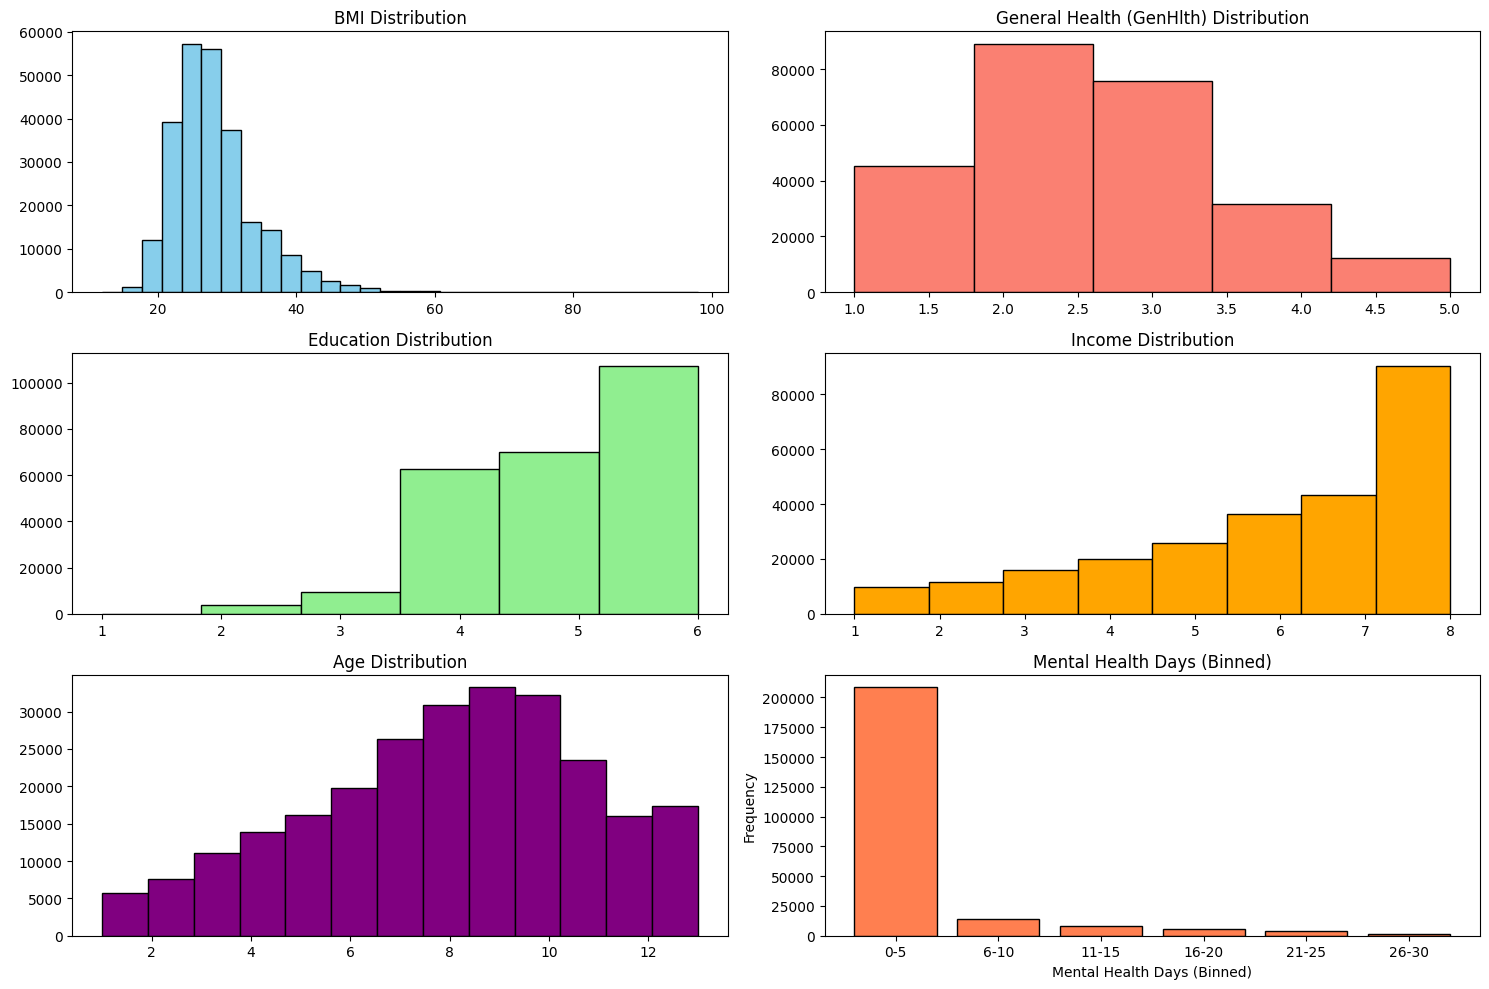

In [44]:

# plot histograms for BMI, General Hlth, Education, Income, Age, and binnes Mental Healt 
plt.figure(figsize=(15, 10))

# histogram for BMI
plt.subplot(3, 2, 1)
plt.hist(X['BMI'], bins=30, color='skyblue', edgecolor='black')
plt.title('BMI Distribution')
plt.plot()

# histogram for GenHlth
plt.subplot(3, 2, 2)
plt.hist(X['GenHlth'], bins=5, color='salmon', edgecolor='black')
plt.title('General Health (GenHlth) Distribution')
plt.plot()

# histogram for Education
plt.subplot(3, 2, 3)
plt.hist(X['Education'], bins=6, color='lightgreen', edgecolor='black')
plt.title('Education Distribution')
plt.plot()

# histogram for Income
plt.subplot(3, 2, 4)
plt.hist(X['Income'], bins=8, color='orange', edgecolor='black')
plt.title('Income Distribution')
plt.plot()

# histogram for Age
plt.subplot(3, 2, 5)
plt.hist(X['Age'], bins=13, color='purple', edgecolor='black')
plt.title('Age Distribution')
plt.plot()

plt.subplot(3, 2, 6)
menthlth_counts = X['MentHlth_binned'].value_counts().sort_index()
plt.bar(menthlth_counts.index, menthlth_counts.values, color='coral', edgecolor='black')
plt.title('Mental Health Days (Binned)')
plt.xlabel('Mental Health Days (Binned)')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()



- BMI Distribution: The BMI distribution reveals a concentration around values between 20 and 30, which generally falls within the normal to overweight categories. There is a notable right tail extending toward higher BMI values (up to around 60–80), suggesting the presence of individuals with severe obesity. This is a critical observation, as high BMI is a known risk factor for diabetes. The spread in BMI values implies that this variable could significantly impact the clustering of diabetic and prediabetic groups, with higher BMI values likely correlating with increased risk.

- General Health (GenHlth) Distribution: The general health distribution skews towards lower values, with a peak around 2, which might indicate that a significant portion of the population perceives their health as relatively good. However, the drop-off at higher values (indicating poorer health) could correspond to individuals with diabetes or related complications. This self-reported health measure could be a valuable factor in identifying clusters with varying health perceptions, possibly aligning with different diabetes risk levels.

- Education Distribution: The education distribution shows an upward trend, with most individuals clustered in the higher education levels. This pattern suggests that the dataset predominantly includes individuals with at least a moderate level of education. Since education level often correlates with health literacy and lifestyle choices, this variable could play a role in differentiating groups within the diabetic and prediabetic population based on lifestyle and preventative health measures.

- Income Distribution: Income distribution is skewed towards the lower end but shows a steady increase, peaking at the highest income bracket. This variation in income levels may influence access to healthcare, nutrition, and exercise options, which are critical factors in diabetes management and prevention. Thus, income could be an important differentiator for clustering patients by socioeconomic risk factors related to diabetes.

- Age Distribution: The age distribution appears relatively balanced, with a peak in middle age (approximately 9–11 on the axis), which corresponds to ages 45-54. This age range is critical for diabetes risk assessment, as middle-aged and older adults have a higher risk of developing diabetes. The spread across age groups provides a comprehensive representation, making it feasible to explore age-related trends in diabetes risk and segmentation.

- Mental Health Days (Binned): The distribution of binned mental health days is heavily skewed towards the 0–5 days category, indicating that most individuals report relatively low mental health burdens. However, there is a smaller but significant number of individuals reporting higher mental health distress (21–30 days), which could correlate with diabetes prevalence, as mental health is both a potential cause and consequence of chronic conditions like diabetes. This variable may help to identify clusters where mental health plays a prominent role, suggesting a need for holistic healthcare approaches.

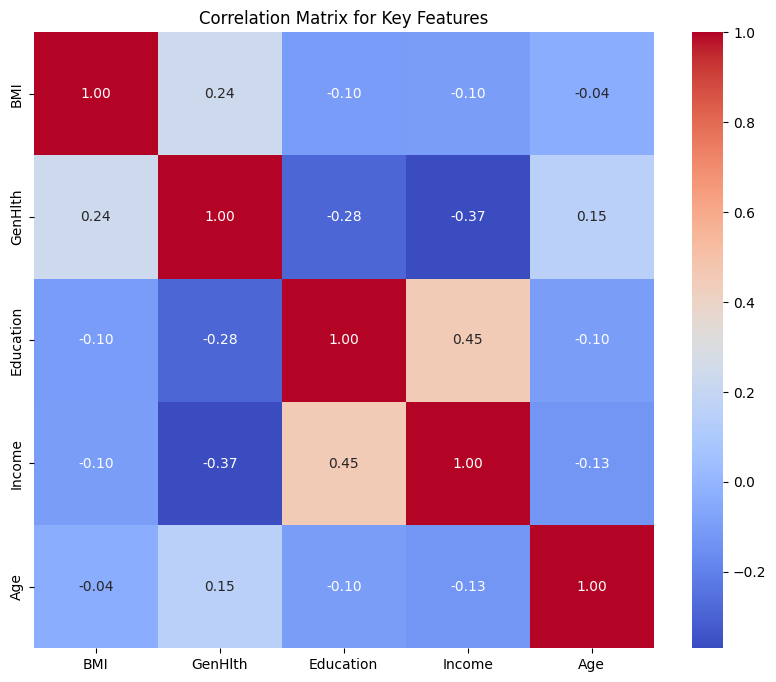

In [53]:
# generate correlation matrix including the target variable 
corr_matrix = X[['BMI', 'GenHlth', 'Education', 'Income', 'Age']].corr()

# plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Key Features')
plt.show()



BMI shows a moderate positive correlation with general health (0.24), suggesting that higher BMI levels are associated with poorer perceived general health. This aligns with existing knowledge that obesity often correlates with chronic health issues and lower self-reported health statuses. The correlations of BMI with other variables like education, income, and age are weak and negative (-0.10, -0.10, and -0.04, respectively), indicating minimal direct influence of these factors on BMI within this dataset.

General Health has a moderate negative correlation with income (-0.37) and education (-0.28), implying that individuals with higher income and education levels tend to report better general health. This relationship is consistent with socioeconomic factors often influencing health outcomes, as those with more resources generally have better access to healthcare, nutrition, and lifestyle options. Additionally, there is a slight positive correlation between general health and age (0.15), which may indicate a trend of perceived health challenges increasing slightly with age, albeit to a limited extent.

Education shows a moderate positive correlation with income (0.45), reflecting a common socioeconomic pattern where higher education levels are associated with higher income. The weak negative correlation between education and age (-0.10) may hint at slight generational differences in educational attainment, where older individuals may have lower average education levels compared to younger cohorts.

Income has a weak negative correlation with age (-0.13), which might suggest that income potential slightly decreases as individuals age, potentially due to retirement or reduced work hours. This aligns with general income patterns across the lifespan.

Age displays minimal correlation with most other variables, except for the slight negative relationship with income and education, indicating that age may not be a strong determinant in this dataset for variables like BMI and general health.

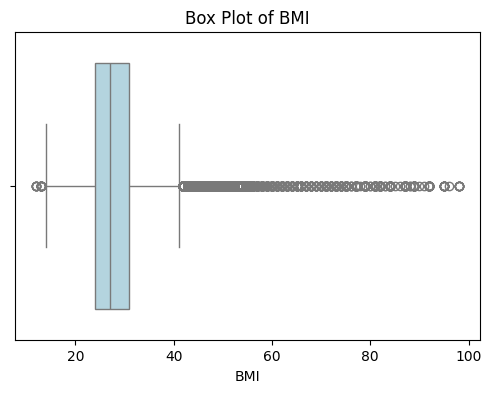

In [46]:
# box plot for bmi to identify potential outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=X['BMI'], color='lightblue')
plt.title('Box Plot of BMI')
plt.show()


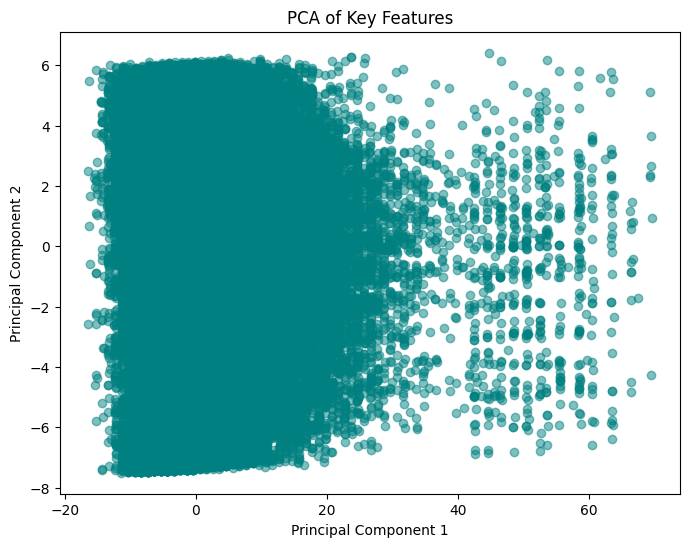

In [50]:

# apply pca to reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X[['BMI', 'GenHlth', 'Education', 'Income', 'Age']])

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5, color='teal')
plt.title('PCA of Key Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()